 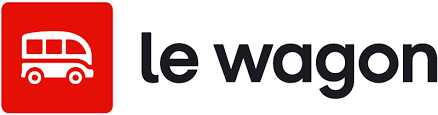

# Trolls detection

# Install Pycaret

We are going to be using the PyCaret libary later on in this challenge, please run the cell below to install it. It might take a minute or so (if you are asked to restart your runtime, please do so)

Once done, run the second cell and you should see "pycaret==*someversion*".

If that's the case you are good to go! If not, and the output is blank, then raise a ticket with a TA!


In [ ]:
# Run first

!pip install pycaret

In [ ]:
# Run second
# If you see an output of pycaret==<some version number>, you're good to go!

!pip freeze | grep pycaret

pycaret==3.3.2


## Data Discovery

In this challenge we are going to try and detect unwanted accounts (trolls) from a social media moderation dataset.

a) Download [moderation.csv](https://drive.google.com/file/d/1twNqS0rd67DhURv2dZiOyjoeRf3s4q-f/view?usp=sharing) and upload it to Colab.

b) Load the data into a `df` variable.

First off, what are the features and the target?

In [ ]:
import pandas as pd

df = pd.read_csv('moderation.csv')

df.head()

,node_id,email,has_picture_cover,has_linkedin,has_twitter,has_personal_url,has_instagram,is_unwanted,tags,goals,nb_chars_in_bio
0,2220753,gmail,0,0,0,0,0,1,NaN,NaN,0.0
1,2213375,yahoo,0,0,0,0,0,1,Music;SocialMediaMarketing;Marketing,Job opportunities,46.0
2,1991442,gmail,1,0,0,0,0,1,NaN,NaN,0.0
3,1962286,hotmail,0,0,0,0,0,1,OfficeManagement;CustomerService;Administratio...,Explore a career change;Job opportunities;Idea...,25.0
4,1968587,gmail,1,1,0,0,0,1,Screenwriting;Fashion;Writing;CopyWriting;Bran...,Mentorship;Job opportunities;Freelance projects,234.0


<details>
    <summary><i>Answer:</i></summary>

Features are:

- `node_id` ⇨ internal and unique id of each user

- `email` ⇨ the email used to register (other refers to emails other than the main ones)

- `has_picture_cover` ⇨ has the user added a picture to their profile?

- `has_linkedin` ⇨ has the user added their LinkedIn handle?

- `has_personal_url` ⇨ has the user added a link to their personal url?

- `has_instagram` ⇨ has the user added their Instagram handle?

- `tags` ⇨ the set of tags in the profile, separated by `;`

- `goals` ⇨ the set of goals chosen by the user, separated by `;`

- `nb_chars_in_bio` ⇨ the number of characters in the profile's bio


`is_unwanted` is the target.

</details>        




Do we have any missing values in our dataset? (Always a good first step)

In [ ]:
df.isnull().sum()

,0
node_id,0
email,0
has_picture_cover,0
has_linkedin,0
has_twitter,0
has_personal_url,0
has_instagram,0
is_unwanted,0
tags,1270
goals,991


Never forget to properly clean your data!

- Replace NaN values in `nb_chars_in_bio` column by 0.
- Replace NaN values in `tags` and `goals` column by "".

After, verify that this has been done.

<details>
    <summary><i>Hint:</i></summary>

Use `.loc[]` and function `.isnull()`, *or* use `.isnull()` and `.sum()`

</details>  

In [ ]:
import numpy as np

columns_to_clean = ['nb_chars_in_bio','tags','goals']

for column in columns_to_clean:

  if df[column].dtype == float:

    df[column].replace(np.NaN, 0, inplace=True)

  elif df[column].dtype == object:

    df[column].replace(np.NaN, "", inplace=True)

In [ ]:
df.isnull().sum()

,0
node_id,0
email,0
has_picture_cover,0
has_linkedin,0
has_twitter,0
has_personal_url,0
has_instagram,0
is_unwanted,0
tags,0
goals,0


c) How many profiles are unwanted? Is the dataset well balanced (i.e. do we have the same number of samples in both classes)?

In [ ]:
df['is_unwanted'].value_counts()

,count
is_unwanted,
0,9000
1,1000


d) Do you think that column `node_id` is relevant for our analysis?

In [ ]:
df.drop(columns=['node_id'], inplace=True)

<details>
    <summary><i>Hint:</i></summary>

Node_id is a unique identifier,
we can delete it.

</details>  

## Feature engineering



Before we starting create models, we need to thoroughly investigate our features to make sure they are both relevant & in the format that we need.

For categorical features, there are few things we should check. One is unique counts.



a) For the 'email' column, how many providers are there?

Represent their distribution in the form of a histogram.

<details>
<summary><i>Hint</i></summary>
    ⟿  Plotly Express has a function "histogram" to make a graph of this distribution: https://plotly.com/python/histograms/

Use the color parameter to distinguish between providers
</details>

In [ ]:
n_providers = df['email'].nunique()

In [ ]:
providers_list = df['email'].unique().tolist()

In [ ]:
print(f"There are {n_providers} providers.\nThese are {providers_list}")

There are 9 providers.
These are ['gmail', 'yahoo', 'hotmail', 'outlook', 'other', 'live', 'orange', 'icloud', 'aol']


In [ ]:
df['email'].value_counts()

,count
email,
gmail,5919
other,1311
hotmail,1160
yahoo,850
outlook,274
live,191
icloud,153
aol,72
orange,70


In [ ]:
import plotly.express as px

px.histogram(df, x='email', color='email')

b) A first simple analysis could be to investigate whether there is a link between a given email provider and the probability of being labeled as 'unwanted'.

Plot this probability in a chart.


<details>
<summary><i>Hint</i></summary>
    ⟿  use `groupby` and `mean` function to calculate probability of being `is_unwanted` by email provider.
    
    ⟿  we can use a `bar` chart of Plotly Express : https://plotly.com/python/bar-charts/
</details>

In [ ]:
email_unwanted = df.groupby(['email'])['is_unwanted'].mean()

email_unwanted

,is_unwanted
email,
aol,0.069444
gmail,0.103565
hotmail,0.103448
icloud,0.137255
live,0.089005
orange,0.128571
other,0.068650
outlook,0.109489
yahoo,0.111765


In [ ]:
px.bar(email_unwanted, range_y=[0,1], labels={'value':'unwanted probability'})

<details>
<summary><i>Explainer</i></summary>
    Because the column `is_unwanted` is a binary categorical feature, we can simply take the mean of the column to get the ratio of our sample that have a value of '1'. As a result, this ratio gives us the probability of a given breakdown being 'unwanted' in our sample.
    
</details>

c) Based on the output of your code above, which email provider is linked to a higher probability of being an 'unwanted' account?

What about the lowest probability?

Based on the probabilities, do you think that email provider is a good predictor of an unwanted account?

If we wanted to investigate this statistically, what test could we do?

<details>
<summary><i>Response</i></summary>

- icloud is the provider linked to the highest rate of unwanted accounts.

- On the other hand, it is the other operators, "Other", that are the least associated with undesirable accounts, could be professional emails.

- Overall, the explanatory variable "email" seems to have a low discriminatory power.

- An Chi-Square test could tell us whether or not there are significant differences between email providers.

</details>

d) Next, lets see if having a `picture cover` the decreases probability of an account being 'unwanted'.

The code below will produce a crosstab that you can use to conduct a Chi-Square test. What conclusion can you draw from the results?

You can also repeat this process with the other boolean variables to see what effect they may have!

In [ ]:
CT = pd.crosstab(index=df['has_picture_cover'], columns=df['is_unwanted'])
CT

is_unwanted,0,1
has_picture_cover,,
0,1461,308
1,7539,692


In [ ]:
import scipy.stats as stats

# Perform Chi-squared test
chiRes = stats.chi2_contingency(CT)

# Print out the p-value
print(f'p-value: {chiRes[1]}')

p-value: 3.788507081379461e-30


e) We want to study the link between `nb_chars_in_bio` and an account being labelled unwanted or not.

Display a boxplot of `nb_chars_in_bio` per `is_unwanted`. What conclusions can you draw?

<details>
<summary><i>Hint</i></summary>
    ⟿  The display can use the "box" function of Plotly Express: https://plotly.com/python/bar-plots/
</details>




In [ ]:
px.box(df, x="nb_chars_in_bio", color = 'is_unwanted')

<details>
<summary><i>Answer</i></summary>

We observe that most unwanted accounts filled their bio with less than 50 letters. In other words, the majority of unwanted accounts put at most a short sentence as their bio.

Legitimate users, on the other hand, put in two to three times as much content.

Visually, it looks like this variable has good discriminatory power.
</details>

In [ ]:
df.head()

,email,has_picture_cover,has_linkedin,has_twitter,has_personal_url,has_instagram,is_unwanted,tags,goals,nb_chars_in_bio
0,gmail,0,0,0,0,0,1,,,0.0
1,yahoo,0,0,0,0,0,1,Music;SocialMediaMarketing;Marketing,Job opportunities,46.0
2,gmail,1,0,0,0,0,1,,,0.0
3,hotmail,0,0,0,0,0,1,OfficeManagement;CustomerService;Administratio...,Explore a career change;Job opportunities;Idea...,25.0
4,gmail,1,1,0,0,0,1,Screenwriting;Fashion;Writing;CopyWriting;Bran...,Mentorship;Job opportunities;Freelance projects,234.0


f) The columns `tags` and `goals` contain account information that could also be used to assess whether accounts are unwanted or not. However, the current format is string data that can't easily be parsed.

Let's create two new columns, `nb_tags` and `nb_goals` that contain the counts of how many tags and goals each user has respectively listed in each of the original columns.

<details>
<summary><i>Hint 1</i></summary>

The function `.count()` counts the number of times a character is found in a string
</details>
<br>

<details>
<summary><i>Hint 2</i></summary>

To apply a string function to a Series, you need to use the attribute `.str` before you chain your function, for example `df[column].str.count(search_string)`
</details>
<br>

<details>
<summary><i>Answer</i></summary>

`df["nb_tags"] = df["tags"].str.count(';') + 1 - (df.tags.str.len() == 0)`

Please ask a TA if you want to walk through the solution!

</details>

In [ ]:
df["nb_tags"] = df["tags"].str.count(';') + 1 - (df.tags.str.len() == 0)
df["nb_goals"] = df["goals"].str.count(';') + 1 - (df.tags.str.len() == 0)

# Modeling

Now that we have performed some feature engineering, we can look into beginning our modelling.

a) First let's only include columns from the original dataframe that will suit our analysis. From `df` create a DataFrame `dataset` that contains the following columns:

 `has_picture_cover`, `has_linkedin`, `has_twitter`, `has_personal_url`, `has_instagram`, `nb_chars_in_bio`, `nb_tags`, `nb_goals`,`is_unwanted`

In [ ]:
columns_to_keep = ['has_picture_cover', 'has_linkedin', 'has_twitter'
, 'has_personal_url', 'has_instagram', 'nb_chars_in_bio', 'nb_tags', 'nb_goals','is_unwanted']

dataset = df[columns_to_keep]

b) As we was earlier, the dataset contains 9 times more normal users (`is_unwanted` == 0) than trolls (`is_unwanted` == 1).

Training a model with this bias is very undesirable! This is because, when classifying a new test case, our model will have learnt that an account is likely to be not be a troll 90% of the time. Hence our model will be highly biased to saying accounts aren't trolls.

We can rectify this by resampling our dataset. Often the safest resampling technique is "under-sampling", where we randomly select a subset of the majority class so that we have balanced classes.

Make sure you understand the code below and then execute it.



In [ ]:
# concatenate is_unwanted users and 1000 randomly selected wanted users
dataset = pd.concat([dataset[dataset['is_unwanted'] == 0].sample(1000),
                     dataset[dataset['is_unwanted'] == 1]])

dataset['is_unwanted'].value_counts()

,count
is_unwanted,
0,1000
1,1000


c) Perform the 80% / 20% split of your dataset with the code below. Again make sure you understand it before running.

What does the `stratify` parameter mean? Why is it useful here?

Also, note that we didn't split between X, y and train / test. This will be useful when we use PyCaret at the end of the challenge.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset
                               ,test_size=0.2
                               ,stratify=dataset['is_unwanted'])

<details>
<summary><i>Answer:</i></summary>
The `stratify = dataset['is_unwanted']` parameter is important because it ensures that the proportion of unwanted individuals remains the when create the train / test sets. An unlucky random slice could result in an unbalanced training / test set, which would hinder our models performance!
</details>
<br>



d) First off, we will create a simple Logistic Regression model. Instantiate and fit a simple Logistic Regression on our train dataset. Be sure to create your X train / test & y train / test.

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train = train.drop(columns='is_unwanted')
X_test = test.drop(columns='is_unwanted')

y_train = train['is_unwanted']
y_test = test['is_unwanted']

simple_log_model = LogisticRegression()

simple_log_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

e) Using our fitted model, generate predictions of the classes from our X_test and save them in a variable called `y_pred`. Use our new `y_pred` variable and our `y_test` to determine the accuracy of our model.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = simple_log_model.predict(X_test)
simple_log_accuracy = accuracy_score(y_test, y_pred)

# OR, more simply:
# simple_log_accuracy = simple_log_model.score(X_test, y_test)

simple_log_accuracy

0.715

f) Given that we are trying to detect unwanted social media accounts, we might be interested in looking at more than just accuracy in terms of our metrics.

If we think that troll accounts are especially harmful, we might want to make sure that we flag as many as we can (even if that increases the likelihood of incorrectly flagging normal accounts as trolls).

What metric would we check how good our model is at capturing as many real unwanted accounts as possible?

Calulate this score.

<details>
<summary><i>Hint:</i></summary>
The recall_score function from sklearn could be usefull.
</details>

In [ ]:
from sklearn.metrics import recall_score

simple_log_recall = recall_score(y_test, y_pred)

simple_log_recall

0.745

Our scores are okay, but not amazing!

Deciding between models and tuning the parameters of those models can be a bit of an art, and requires a fair amount of practice to determine which parameters are suitable for a given task.

However, to simplify things, we can use the **PyCaret** library! This will try a whole range of models on our data and show us how they all perform on a number of different metrics in just a few lines of code.

d) Complete the following code:

Remember which data variables to use, and to also pay attention to the `normalize` parameter.

In [ ]:
from pycaret.classification import setup

xp = setup(data = train,
           test_data = test,
           target = "is_unwanted",
           normalize = True,
           session_id = 42)

,Description,Value
0,Session id,42
1,Target,is_unwanted
2,Target type,Binary
3,Original data shape,"(2000, 9)"
4,Transformed data shape,"(2000, 9)"
5,Transformed train set shape,"(1600, 9)"
6,Transformed test set shape,"(400, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


e) Screen the PyCaret models and compare their performance by executing cell below.

Which model has the best accuracy?

In [ ]:
from pycaret.classification import compare_models

best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7075,0.7569,0.6975,0.7115,0.7034,0.4150,0.4162,0.1380
gbc,Gradient Boosting Classifier,0.7006,0.7534,0.6862,0.7062,0.6951,0.4012,0.4023,0.1730
lr,Logistic Regression,0.6944,0.7576,0.7188,0.6860,0.7009,0.3888,0.3905,0.6410
ridge,Ridge Classifier,0.6919,0.7573,0.7138,0.6844,0.6978,0.3838,0.3853,0.0340
lda,Linear Discriminant Analysis,0.6919,0.7573,0.7138,0.6844,0.6978,0.3838,0.3853,0.0480
knn,K Neighbors Classifier,0.6694,0.6977,0.6450,0.6776,0.6600,0.3388,0.3399,0.1050
lightgbm,Light Gradient Boosting Machine,0.6606,0.7281,0.6550,0.6640,0.6582,0.3212,0.3223,0.4630
svm,SVM - Linear Kernel,0.6562,0.7087,0.6413,0.6615,0.6491,0.3125,0.3144,0.0420
nb,Naive Bayes,0.6556,0.7457,0.8212,0.6185,0.7050,0.3113,0.3297,0.0360
xgboost,Extreme Gradient Boosting,0.6444,0.7030,0.6425,0.6453,0.6426,0.2887,0.2897,0.1090


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

<details>
<summary><i>Answer:</i></summary>

The best model is likely the `gradient boosting classifier` - gradient boosted models (of various kinds) often perform the best at competitions so this is not surprising!

We should also see that a simple `logistic regression` model performs quite highly, with around 72% accuracy, with scores in a similar range for recall / accuracy.

Looking at the performances of the other classifiers, we can also note:

- Several classifiers offer relatively similar performances at the top of the ranking, which seems to indicate a global convergence towards an optimum across the different models.

- We can observe the Precision/Recall trade-off in the classifiers' scores: models with an especially high score in one should see a corresponding decrease in performance of the other!
</details>
<br>



f) Display matrix confusion for your best model using plot_model function.

(You can refer to the lecture for the correct syntax)

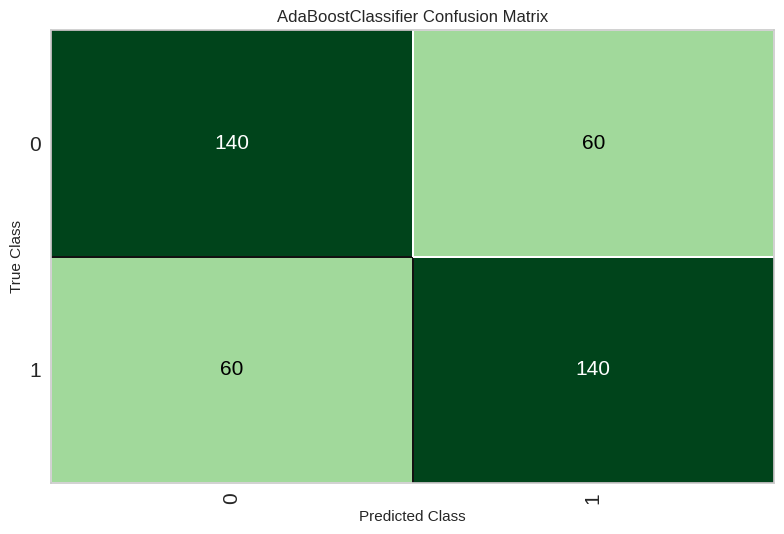

In [ ]:
from pycaret.classification import plot_model

plot_model(best_model, plot='confusion_matrix')

g) Every model has different parameters that you can fine-tune. As with choosing the intial model, we can use PyCaret to find us the best parameters of our model!

This can be done with a simple call to the `tune_model` function, [described here](https://pycaret.org/tune-model/).

Execute cell below. Has the performance of our best model improved?

In [ ]:
from pycaret.classification import tune_model

best_model_tuned = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6438,0.6766,0.5875,0.6620,0.6225,0.2875,0.2893
1,0.7562,0.8188,0.7125,0.7808,0.7451,0.5125,0.5145
2,0.7438,0.8384,0.7375,0.7468,0.7421,0.4875,0.4875
3,0.6812,0.7234,0.7375,0.6629,0.6982,0.3625,0.3648
4,0.6750,0.7562,0.6375,0.6892,0.6623,0.3500,0.3510
5,0.7500,0.7730,0.8000,0.7273,0.7619,0.5000,0.5025
6,0.7250,0.7616,0.7375,0.7195,0.7284,0.4500,0.4501
7,0.7312,0.8045,0.6875,0.7534,0.7190,0.4625,0.4643
8,0.7312,0.7698,0.7000,0.7467,0.7226,0.4625,0.4634


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


We can also see the exact parameters that were chosing during the model tuning by running the cell below:

In [ ]:
best_model_tuned.get_params()

{'algorithm': 'SAMME',
 'estimator': None,
 'learning_rate': 0.3,
 'n_estimators': 190,
 'random_state': 42}

<details>
<summary><i>Answer:</i></summary>

Each fold is a specific split of our data.

If we look at the 'mean' row, the overall performance is not really better. So it seems like tuning our model didn't improve our scores of the default values!
</details>
<br>




h) We might also want to know exactly which features were most important to our model out of the data that was fed in.

To create the features importance graph, call the function `plot_model()` with the model of your choice and add the argument plot="feature".

How do you interpret these values?

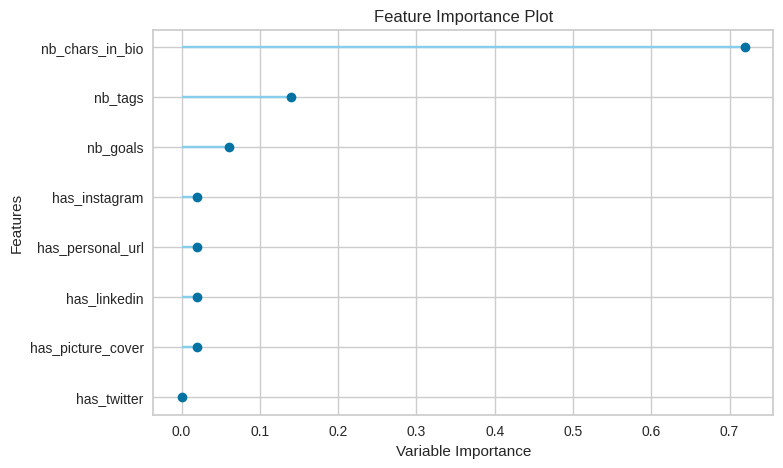

In [ ]:
plot_model(best_model,'feature')